In [1]:
import h5py
import numpy as np
import scipy.signal as scis
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
def load_data(path='mnist.h5'):
    with h5py.File(path, 'r') as handle:
        return np.array(handle['data']), np.array(handle['labels'])
    
data, labels = load_data()

In [3]:
gauss_filter = scis.convolve2d(data[0], np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]), mode='same')

laplacian_filter = scis.convolve2d(data[0], np.array([
    [0,  1, 0],
    [1, -4, 1],
    [0,  1, 0]
]), mode='same')

high_pass_filter = scis.convolve2d(data[0], np.array([
    [-1, -1, -1],
    [-1,  9, -1],
    [-1, -1, -1]
]), mode='same')

sharpen = scis.convolve2d(data[0], np.array([
    [-0.5, -0.5, -0.5],
    [-0.5,  8.5, -0.5],
    [-0.5, -0.5, -0.5]
]), mode='same')

sobel_x = scis.convolve2d(data[0], np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
]), mode='same')

sobel_y = scis.convolve2d(data[0], np.array([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1,]
]), mode='same')

sobel = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

emboss_filter = scis.convolve2d(data[0], np.array([
    [-1, -1,  0],
    [-1,  0,  1],
    [ 0,  1,  1,]
]), mode='same')

In [4]:
gauss_filter_5x5 = scis.convolve2d(data[0], np.array([
    [1,  4,  7,  2,  1],
    [4, 16, 26, 16,  4],
    [7, 26, 41, 26,  7],
    [4, 16, 26, 16,  4],
    [1,  4,  7,  4,  1],
]), mode='same')

laplacian_filter_5x5 = scis.convolve2d(data[0], np.array([
    [0, 0,   1, 0, 0],
    [0, 1,   2, 1, 0],
    [1, 2, -16, 2, 1],
    [0, 1,   2, 1, 0],
    [0, 0,   1, 0, 0]
]), mode='same')

high_pass_filter_5x5 = scis.convolve2d(data[0], np.array([
    [ 0, -1, -1, -1,  0],
    [-1,  2, -4,  2, -1],
    [-1, -4, 13, -4, -1],
    [-1,  2, -4,  2, -1],
    [ 0, -1, -1, -1,  0]
]), mode='same')

sharpen_5x5 = scis.convolve2d(data[0], np.array([
    [-0.5, -0.5,  -0.5, -0.5, -0.5],
    [-0.5, -0.5,  -0.5, -0.5, -0.5],
    [-0.5, -0.5,  24.5, -0.5, -0.5],
    [-0.5, -0.5,  -0.5, -0.5, -0.5],
    [-0.5, -0.5,  -0.5, -0.5, -0.5],
]), mode='same')

sobel_x_5x5 = scis.convolve2d(data[0], np.array([
    [2, 1, 0, -1, -2],
    [2, 1, 0, -1, -2],
    [4, 2, 0, -2, -4],
    [2, 1, 0, -1, -2],
    [2, 1, 0, -1, -2]
]), mode='same')

sobel_y_5x5 = scis.convolve2d(data[0], np.array([
    [ 1,  1,  4,  1,  1],
    [ 1,  1,  2,  1,  1],
    [ 0,  0,  0,  0,  0],
    [-1, -1, -2, -1, -1],
    [-1, -1, -4, -1, -1],
]), mode='same')

sobel_5x5 = np.sqrt(sobel_x_5x5 ** 2 + sobel_y_5x5 ** 2)

emboss_filter_5x5 = scis.convolve2d(data[0], np.array([
    [-1, -1, -1, -1, 0],
    [-1, -1, -1,  0, 1],
    [-1, -1,  0,  1, 1],
    [-1,  0,  1,  1, 1],
    [ 0,  1,  1,  1, 1],
]), mode='same')

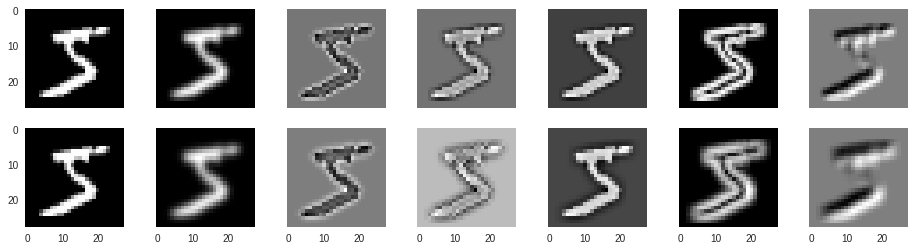

In [5]:
def show_examples(data):
    height = data.shape[0]
    width = data.shape[1]
    figure, axes = plt.subplots(height, width, figsize=(16, 4), sharex=True, sharey=True)
    
    for h in range(height):
        for w in range(width):
            axis = axes[h][w]
            axis.grid(False)
            axis.imshow(data[h, w, :, :], cmap='gist_gray')
    plt.show()

    
filtered_images = np.array([
    [data[0], gauss_filter,     laplacian_filter,     high_pass_filter,     sharpen,     sobel,     emboss_filter],
    [data[0], gauss_filter_5x5, laplacian_filter_5x5, high_pass_filter_5x5, sharpen_5x5, sobel_5x5, emboss_filter_5x5]
])
show_examples(filtered_images)

In [6]:
def preprocess_data(data, labels):
    return np.expand_dims(data, axis=3), to_categorical(labels)

preprocessed_data, preprocessed_labels = preprocess_data(data, labels)

In [7]:
def build_model(data, classes):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=data.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_model(preprocessed_data, classes=preprocessed_labels.shape[1])

In [8]:
class TrainingHistory(Callback):
    def on_train_begin(self, logs):
        self.loss = []
        self.acc = []
        self.validation_loss = []
        self.validation_acc = []
        
    def on_batch_end(self, _, logs):
        if 'loss' in logs:
            self.loss.append(logs['loss'])
        if 'acc' in logs:
            self.acc.append(logs['acc'])
            
    def on_epoch_end(self, _, logs):
        if 'val_loss' in logs:
            self.validation_loss.append(logs['val_loss'])
        if 'val_acc' in logs:
            self.validation_acc.append(logs['val_acc'])

In [9]:
def train_model(model, data, labels, epochs=10, batch_size=64, train_fraction=0.8):
    history = TrainingHistory()
    model.fit(
        data, 
        labels, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_split=1.0 - train_fraction, 
        shuffle=True,
        callbacks=[history]
    )
    return history
    
history = train_model(model, preprocessed_data, preprocessed_labels)

Train on 56000 samples, validate on 14000 samples
Epoch 1/10
56000/56000 [==============================] - 149s 3ms/step - loss: 0.5489 - acc: 0.8435 - val_loss: 0.2150 - val_acc: 0.9391
Epoch 2/10
56000/56000 [==============================] - 148s 3ms/step - loss: 0.1880 - acc: 0.9438 - val_loss: 0.1233 - val_acc: 0.9649
Epoch 3/10
56000/56000 [==============================] - 151s 3ms/step - loss: 0.1293 - acc: 0.9615 - val_loss: 0.0929 - val_acc: 0.9743
Epoch 4/10
56000/56000 [==============================] - 148s 3ms/step - loss: 0.0988 - acc: 0.9700 - val_loss: 0.0816 - val_acc: 0.9760
Epoch 5/10
56000/56000 [==============================] - 159s 3ms/step - loss: 0.0817 - acc: 0.9748 - val_loss: 0.0673 - val_acc: 0.9798
Epoch 6/10
56000/56000 [==============================] - 142s 3ms/step - loss: 0.0696 - acc: 0.9786 - val_loss: 0.0662 - val_acc: 0.9800
Epoch 7/10
56000/56000 [==============================] - 206s 4ms/step - loss: 0.0595 - acc: 0.9812 - val_loss: 0.0642 - 

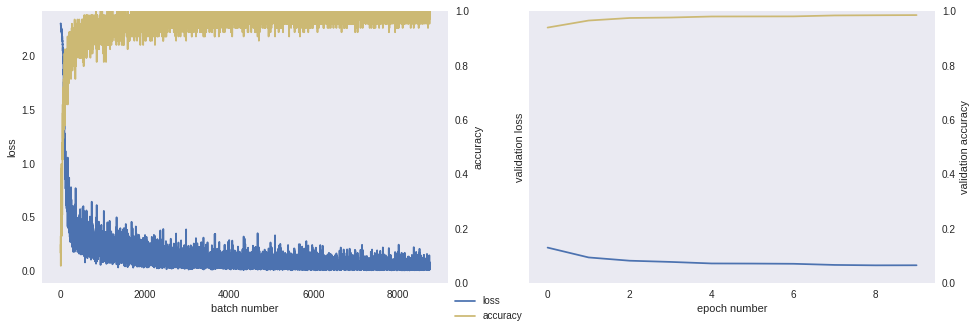

In [10]:
def plot_history(history):
    figure, (batch_axis, epoch_axis) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    
    # plot the training loss and accuracy
    batch_axis.set_xlabel('batch number')
    training_batches = np.arange(len(history.loss))
    
    batch_axis.grid(False)
    batch_axis.plot(training_batches, history.loss, color='C0', label='loss')
    batch_axis.set_ylabel('loss')
    
    batch_acc_axis = batch_axis.twinx()
    batch_acc_axis.grid(False)
    batch_acc_axis.set_ylabel('accuracy')
    batch_acc_axis.set_ylim(bottom=0.0)
    batch_acc_axis.plot(training_batches, history.acc, color='C4', label='accuracy')
    
    # plot the training loss and accuracy
    epoch_axis.set_xlabel('epoch number')
    validation_epochs = np.arange(len(history.validation_loss))
    
    epoch_axis.grid(False)
    epoch_axis.plot(validation_epochs, history.validation_loss, color='C0')
    epoch_axis.set_ylabel('validation loss')
    
    epoch_acc_axis = epoch_axis.twinx()
    epoch_acc_axis.grid(False)
    epoch_acc_axis.set_ylabel('validation accuracy')
    epoch_acc_axis.set_ylim(bottom=0.0)
    epoch_acc_axis.plot(validation_epochs, history.validation_acc, color='C4')
    
    # display a legend
    figure.legend(loc=8)
    plt.show()

plot_history(history)

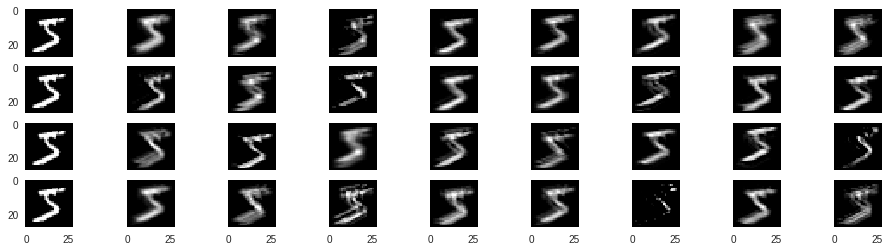

In [12]:
def apply_network_convolutions(image, weights):
    height, width = image.shape
    kernels_y, kernels_x = weights.shape[:2]
    
    output = np.zeros((kernels_y, kernels_x + 1, height, width), dtype=image.dtype)
    for y in range(kernels_y):
        for x in range(kernels_x + 1):
            if x == 0:
                output[y, x, :, :] = image
            else:
                output[y, x, :, :] = scis.convolve2d(image, weights[y, x - 1, :, :], mode='same')
    return output


weights = np.moveaxis(model.get_weights()[0], 0, -1).reshape(4, 8, 5, 5)
model_convolutions = apply_network_convolutions(data[0], weights)
show_examples(model_convolutions)